# Multinomial NNGP demonstration

This notebook runs the multinomial NNGP Gibbs sampler and visualises the posterior mean of source compositions.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from bayesian_statistics.models.preprocessing.data_preprocessor import (
    ObsidianDataPreprocessor,
)
from bayesian_statistics.nngp.model import (
    MultinomialNNGPConfig,
    prepare_multinomial_dataset,
    run_mcmc,
)

data_dir = "/home/ohta/dev/bayesian_statistics/data"
preprocessor = ObsidianDataPreprocessor(data_dir, scale_variables=True)
preprocessor.load_data()

period = 1
origins = ["神津島", "信州", "箱根", "高原山", "その他"]
variable_names = [
    "average_elevation",
    "average_slope_angle",
    "cost_kouzu",
    "cost_shinshu",
    "cost_hakone",
    "cost_takahara",
    "cost_river",
]

dataset = prepare_multinomial_dataset(
    preprocessor=preprocessor,
    period=period,
    origins=origins,
    variable_names=variable_names,
    grid_subsample_ratio=0.1,  # subsample grid points for speed
    drop_zero_total_sites=True,  # すべての観測値が0の地点を除外する
)

config = MultinomialNNGPConfig(
    n_iter=200,
    burn_in=50,
    thinning=1,
    neighbor_count=40,
    kernel_lengthscale=0.15,
    kernel_variance=1,
    seed=42,
)

# Example: per-feature kernel settings (commented out by default)
# config = MultinomialNNGPConfig(
#     n_iter=200,
#     burn_in=50,
#     thinning=5,
#     neighbor_count=40,
#     kernel_lengthscale=0.05,
#     kernel_variance=1.0,
#     kernel_lengthscale_by_feature=[
#         0.05,  # intercept
#         0.04,  # average_elevation
#         0.04,  # average_slope_angle
#         0.06,  # cost_kouzu
#         0.06,  # cost_shinshu
#         0.06,  # cost_hakone
#         0.06,  # cost_takahara
#         0.06,  # cost_river
#     ],
#     kernel_variance_by_feature=[
#         1.0,  # intercept
#         1.0,  # average_elevation
#         1.0,  # average_slope_angle
#         0.8,  # cost_kouzu
#         0.8,  # cost_shinshu
#         0.8,  # cost_hakone
#         0.8,  # cost_takahara
#         0.8,  # cost_river
#     ],
#     seed=42,
# )

results = run_mcmc(dataset, config)
site_mean = results.posterior_site_mean()
grid_mean = results.posterior_grid_mean(sample_conditional=False)
print(f"Saved samples: {results.num_draws()}")

1. building NNGP factor cache for 61 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 135752/135752 [01:17<00:00, 1754.98it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 51.54it/s]


Saved samples: 150


In [64]:
beta = results.beta_samples

In [65]:
beta_sites = beta[:, 0, 0].mean(axis=0)

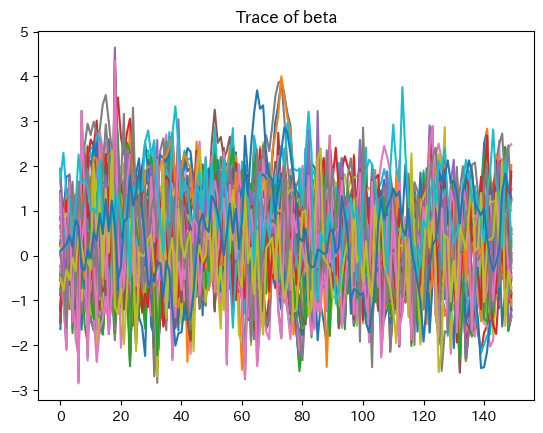

In [ ]:
plt.title("Trace of beta")
plt.plot(beta[:, 0, 0])

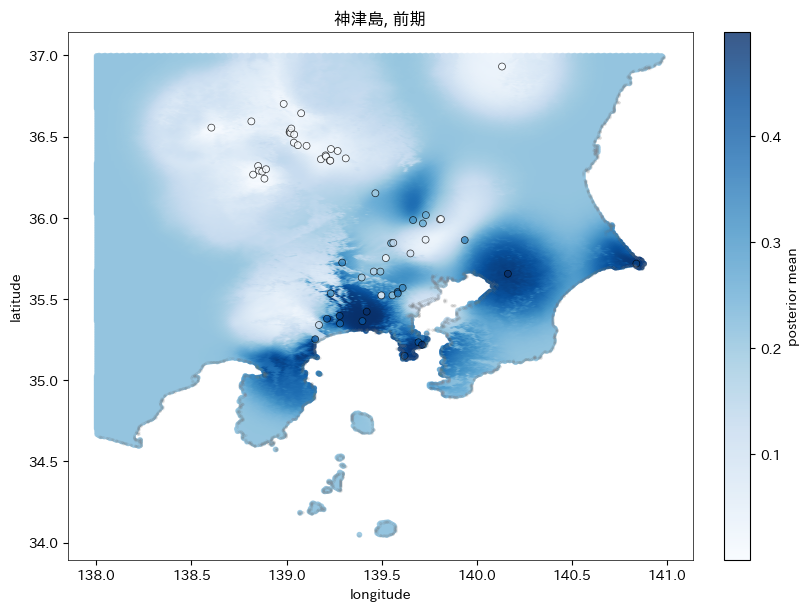

In [84]:
origin_index = 0

time_periods = {0: "早期・早々期", 1: "前期", 2: "中期", 3: "後期", 4: "晩期"}

import polars as pl

boundary = (
    preprocessor.df_elevation.filter(
        pl.col("average_elevation").is_null(), ~pl.col("is_sea")
    )
    .select(["x", "y"])
    .to_numpy()
)
true_ratio = dataset.counts / dataset.counts.sum(axis=1, keepdims=True)
true_ratio = np.nan_to_num(true_ratio).T

true_ratio


def plot_result(origin_index: int, covariate_index: int = 0):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)

    subset = np.linspace(0, dataset.grid_points.shape[0] - 1, 10000, dtype=int)
    ax.scatter(
        dataset.grid_points[:, 0],
        dataset.grid_points[:, 1],
        c=grid_mean[origin_index, :],
        cmap="Blues",
        s=10,
        alpha=0.8,
    )

    beta_sites = beta[:, origin_index, covariate_index].mean(axis=0)
    ax.scatter(
        dataset.coords[:, 0],
        dataset.coords[:, 1],
        c=true_ratio[origin_index],
        cmap="Blues",
        s=25,
        edgecolors="black",
        linewidths=0.5,
        alpha=0.8,
        label="beta (intercept) at sites",
    )
    ax.scatter(boundary[:, 0], boundary[:, 1], c="grey", s=0.001)
    # colorbar
    plt.colorbar(ax.collections[0], ax=ax, label="posterior mean")
    ax.set_title(f"{origins[origin_index]}, {time_periods[period]}")
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")

    # 枠線を細くする
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    plt.show()


plot_result(0)

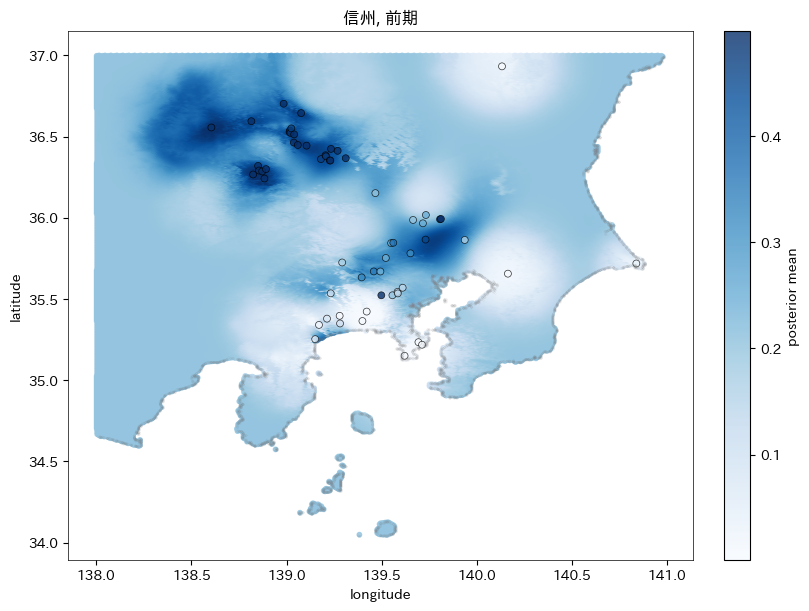

In [85]:
plot_result(1)

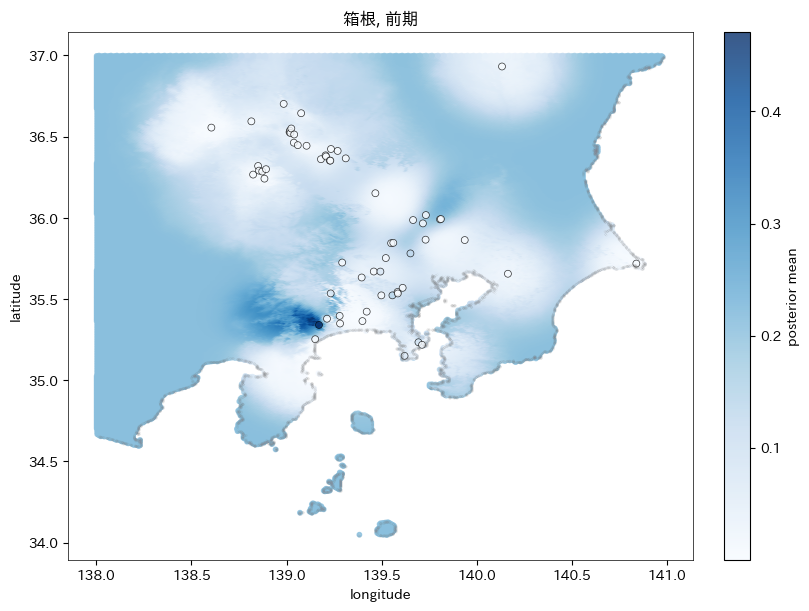

In [86]:
plot_result(2)

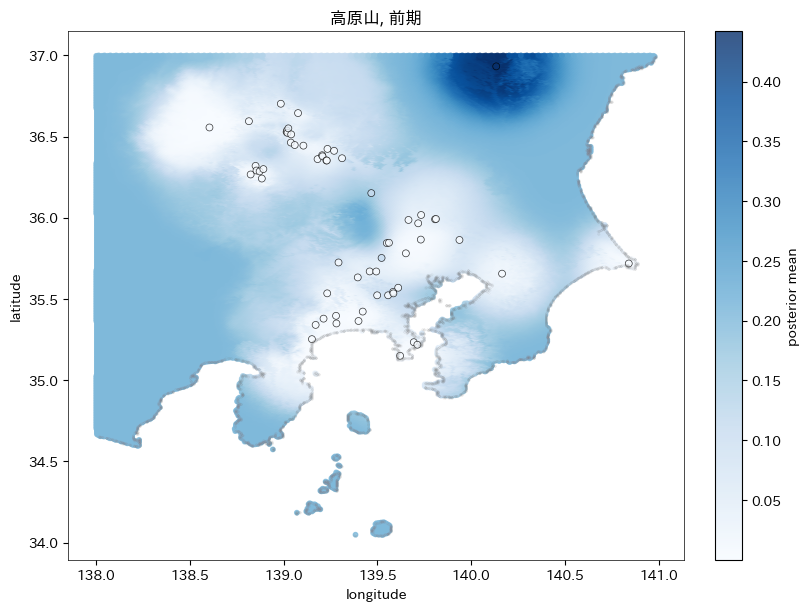

In [87]:
plot_result(3)